# Vodafone Task (Leeds 2011: Car Accidents Severity Classification)

### By: Adham Gamal

---
---
---

## Libraries

In [1]:
import pandas as pd
import numpy as np
from utils import data_utils, pipeline_utils, plot_utils

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE

import warnings
warnings.simplefilter("ignore", category=UserWarning)

---
---
---

## Data wrangling

In [2]:
def wrangle(path):
    # Load the data from the specified path
    data = pd.read_excel(path)

    # Bin 'Age of Casualty' into groups and create a new column 'Age Group'
    ages = data['Age of Casualty']
    age_bins = np.arange(ages.min(), ages.max(), 10)
    data['Age Group'] = pd.cut(ages, bins=age_bins, labels=[f'{i}' for i in range(len(age_bins)-1)], right=False)

    # Mapping Features to reduce reduce imbalance
    data['Type of Vehicle'] = data['Type of Vehicle'].apply(data_utils.map_vehicle_type)

    classes_to_combine = ['A(M)', 'B', 'Motorway']
    data['1st Road Class'] = data['1st Road Class'].apply(lambda x: 'Other' if x in classes_to_combine else x)

    classes_to_combine = [3, 4, 5, 6, 8]
    data['Number of Vehicles'] = data['Number of Vehicles'].apply(lambda x: 'Other' if x in classes_to_combine else x)

    data['Lighting Conditions'] = data['Lighting Conditions'].map(lambda x: 'Daylight' if str(x).startswith('Daylight') else 'Darkness')
    data['Weather Conditions'] = data['Weather Conditions'].map(lambda x: 'Fine' if str(x).startswith('Fine without') else 'Risky')
    
    # Drop columns with high cardinality or less relevance to modeling:
    #   - 'Accident Date', 'Time (24hr)', 'District', 'Address' high cardinality and less relevance to modeling.
    #   - 'Road Surface' highly correlated with 'Weather Conditions' and less correlated with target.
    #   - 'Age of Casualty' converted to 'Age Group'
    columns_to_drop = ['Accident Date', 'Time (24hr)', 'District', 'Address', 'Road Surface', 'Age of Casualty']
    data.drop(columns=columns_to_drop, inplace=True)

    # Convert all columns to strings, as all are categorical or will be converted to categorical
    data = data.astype(str)

    display(data.head())

    # Convert data to labels using LabelEncoder to ease the modeling process
    label_encoder = LabelEncoder()
    preprocessed_data = data.apply(label_encoder.fit_transform)

    display(preprocessed_data.head())

    # Return the preprocessed data
    return preprocessed_data


In [3]:
data = wrangle('data/Road Accidents with Address.xlsx')

Number of Vehicles 1st Road Class Lighting Conditions Weather Conditions  \
0                  2          Other            Darkness              Risky   
1                  2   Unclassified            Daylight              Risky   
2                  1              A            Daylight               Fine   
3                  1              A            Darkness               Fine   
4                  2              A            Daylight               Fine   

  Casualty Class Casualty Severity Sex of Casualty Type of Vehicle Age Group  
0         Driver            Slight            Male             Car         6  
1         Driver            Slight          Female             Car         3  
2     Pedestrian           Serious            Male             Car         6  
3     Pedestrian           Serious            Male           Other         3  
4         Driver            Slight            Male             Car         2

Number of Vehicles  1st Road Class  Lighting Conditions  \
0                   1               1                    0   
1                   1               2                    1   
2                   0               0                    1   
3                   0               0                    0   
4                   1               0                    1   

   Weather Conditions  Casualty Class  Casualty Severity  Sex of Casualty  \
0                   1               0                  2                1   
1                   1               0                  2                0   
2                   0               2                  1                1   
3                   0               2                  1                1   
4                   0               0                  2                1   

   Type of Vehicle  Age Group  
0                1          6  
1                1          3  
2                1          6  
3                3          3  
4                1          2

---

## Split Data into X, y

In [4]:
X = data.drop('Casualty Severity', axis=1)
y = data['Casualty Severity']

---
---
---

## Feature Selection

### Tree-Based Feature Importance Selection

In [5]:
clf = RandomForestClassifier(n_estimators=20, random_state=42)
clf = clf.fit(X, y)

# Fit the SelectFromModel
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

# Get the feature indices selected by SelectFromModel
selected_features = np.where(model.get_support())[0]

# Get the original feature names
original_feature_names = X.columns

# Get the selected feature names
selected_feature_names = original_feature_names[selected_features]

# Display the selected feature names
print("Selected Features:", selected_feature_names.to_list())

Selected Features: ['Type of Vehicle', 'Age Group']


---

### Filter Method (Chi-squared Test):

In [6]:
# Select the number of features you want to keep
k_best = 5  # You can adjust this number based on your preference

# Use SelectKBest with chi-squared test for feature selection
X_new = SelectKBest(chi2, k=k_best).fit_transform(X, y)

# Get the original feature names
original_feature_names = X.columns

# Get the selected feature indices
selected_features = np.argsort(-SelectKBest(chi2, k=k_best).fit(X, y).scores_)[0:k_best]

# Get the selected feature names
selected_feature_names = original_feature_names[selected_features]

# Display the selected feature names
print("Selected Features:", selected_feature_names.to_list())

Selected Features: ['Number of Vehicles', 'Type of Vehicle', 'Age Group', 'Casualty Class', 'Weather Conditions']


---

### Wrapper Method (Recursive Feature Elimination with SVM):

In [7]:
# Specify the number of features you want to keep
num_features_to_keep = 5  # Adjust this based on your preference

# Create an SVM classifier
svc = SVC(kernel="linear", random_state=42)

# Use RFE for feature selection
rfe = RFE(estimator=svc, n_features_to_select=num_features_to_keep)
X_new = rfe.fit_transform(X, y)

# Get the original feature names
original_feature_names = X.columns

# Get the selected feature names
selected_features = np.where(rfe.support_)[0]
selected_feature_names = original_feature_names[selected_features]

# Display the selected feature names
print("Selected Features:", selected_feature_names.to_list())

Selected Features: ['1st Road Class', 'Lighting Conditions', 'Casualty Class', 'Sex of Casualty', 'Type of Vehicle']


---

### Embedded Method (Random Forest Feature Importance):

In [8]:
# Specify the number of features you want to keep
num_features_to_keep = 5  # Adjust this based on your preference

# Create a random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=20, random_state=42)
rf_classifier.fit(X, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Sort indices of features by importance
sorted_feature_indices = np.argsort(feature_importances)[::-1]

# Select the top features
selected_feature_indices = sorted_feature_indices[:num_features_to_keep]

# Get the original feature names
original_feature_names = X.columns

# Get the selected feature names
selected_feature_names = original_feature_names[selected_feature_indices]

# Display the selected feature names
print("Selected Features:", selected_feature_names.to_list())

Selected Features: ['Age Group', 'Type of Vehicle', '1st Road Class', 'Number of Vehicles', 'Casualty Class']


**Conclusion:**
- Features selected over different approaches:
    - ['Type of Vehicle', 'Age Group']
    - ['Number of Vehicles', 'Type of Vehicle', 'Age Group', 'Casualty Class', 'Weather Conditions']
    - ['1st Road Class', 'Lighting Conditions', 'Casualty Class', 'Sex of Casualty', 'Type of Vehicle']
    - ['Age Group', 'Type of Vehicle', '1st Road Class', 'Number of Vehicles', 'Casualty Class']

- Common features:
    - 'Number of Vehicles', 'Type of Vehicle', 'Age Group', 'Casualty Class', '1st Road Class'

- These common features ensure our understanding that:
    - 'Lighting Conditions', 'Weather Conditions' are biased towards one majority class and may need to be dropped.
    - Also, 'Sex of Casualty' does not appear to be highly effective as the data is distributed equally with the same rate.

- Therefore, I will try both approaches and compare their performance.

---
---
---

## Selected Models

### 1. Random Forest:

#### How it works:
- **Ensemble Method:** Random Forest is an ensemble learning method that operates by constructing a multitude of decision trees during training and outputs the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

#### Hyperparameters:

- **`n_estimators`:** The number of trees in the forest. Increasing the number of trees generally improves model performance, up to a certain point. However, more trees also mean longer training times.
- **`max_depth`:** The maximum depth of the trees. A deeper tree can capture more complex patterns, but it may lead to overfitting. It's essential to find the right balance.

### 2. Gradient Boosting:

#### How it works:
- **Sequential Training of Trees:** Gradient Boosting builds trees sequentially, with each tree correcting errors made by the previous ones. It combines weak learners into a strong learner.

#### Hyperparameters:

- **`n_estimators`:** The number of boosting stages to be run. Increasing this value generally improves model performance, but it also requires more computation.
- **`max_depth`:** The maximum depth of the individual trees. Controls the complexity of the trees.

### 3. XGBoost:

#### How it works:
- **Extreme Gradient Boosting:** XGBoost is an optimized and efficient implementation of the gradient boosting algorithm. It uses a technique called regularized boosting, which helps control overfitting.

#### Hyperparameters:

- **`n_estimators`, `max_depth`:** Similar to Gradient Boosting, these parameters control the number of boosting rounds and the maximum depth of the trees.

### 4. Support Vector Machine (SVM):

#### How it works:
- **Maximum Margin Classifier:** SVM aims to find the hyperplane that best separates data points of different classes while maximizing the margin between classes. It is effective in both linear and non-linear classification tasks.

#### Hyperparameters:

- **`C`:** The regularization parameter. It controls the trade-off between achieving a smooth decision boundary and classifying training points correctly. Smaller values (e.g., 0.001 to 1) may prevent overfitting, while larger values (e.g., 10 to 100) may allow the model to fit the training data more closely.
- **`kernel`:** The kernel function determines the type of decision boundary the model will use. Common choices include 'linear' and 'rbf' (Radial basis function). 'Linear' is suitable for linearly separable data, while 'rbf' is more flexible and can capture non-linear relationships.

### 5. Naive Bayes (MultinomialNB):

#### How it works:
- **Probabilistic Classifier:** Naive Bayes is a probabilistic classifier based on Bayes' theorem, assuming independence between features. The MultinomialNB variant is suitable for discrete data, often used in text classification.

#### Hyperparameters:

- **`alpha`:** A smoothing parameter that prevents zero probabilities. It is crucial to handle cases where a feature did not appear in the training data, ensuring the model can make predictions for unseen features. Common choices for alpha include small values like 0.1 or 1.

---
---
---

## Selected Sampling Techniques:

- SMOTE (Synthetic Minority Over-sampling Technique): Generates synthetic samples by interpolating between existing minority class instances.
- ADASYN (Adaptive Synthetic Sampling): Similar to SMOTE but focuses on generating synthetic samples for harder-to-classify instances.
- Borderline-SMOTE: A variant of SMOTE that generates synthetic samples near the borderline between the minority and majority classes.

---
---
---

## Methodology

In [9]:
X = data[['Number of Vehicles', 'Type of Vehicle', 'Age Group', 'Casualty Class', '1st Road Class']]
y = data['Casualty Severity']

metrics = ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score']

Running GridSearchCV for Random Forest...
Best Hyperparameters for Pipeline: {'model__n_estimators': 100}
Best Accuracy: 0.8763
Test Accuracy: 0.8745

Classification Report
              precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00         5
     Serious       0.21      0.06      0.09        53
      Slight       0.89      0.98      0.93       460

    accuracy                           0.87       518
   macro avg       0.37      0.34      0.34       518
weighted avg       0.82      0.87      0.84       518
 

Confusion Matrix:


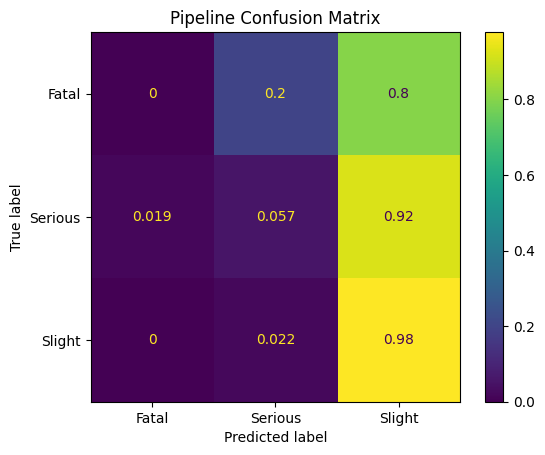

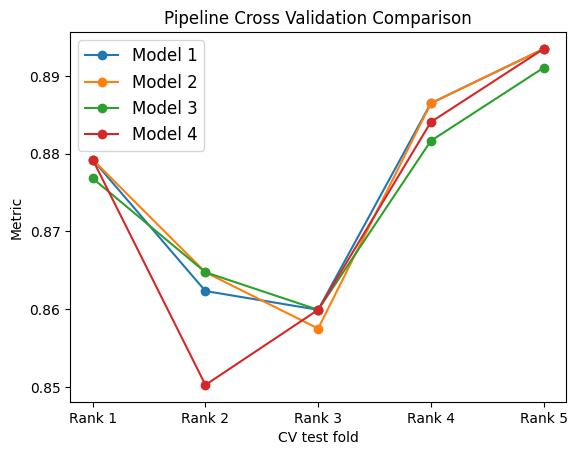

Running GridSearchCV for Gradient Boosting...
Best Hyperparameters for Pipeline: {'model__n_estimators': 200}
Best Accuracy: 0.8830
Test Accuracy: 0.8861

Classification Report
              precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00         5
     Serious       0.33      0.04      0.07        53
      Slight       0.89      0.99      0.94       460

    accuracy                           0.89       518
   macro avg       0.41      0.34      0.34       518
weighted avg       0.83      0.89      0.84       518
 

Confusion Matrix:


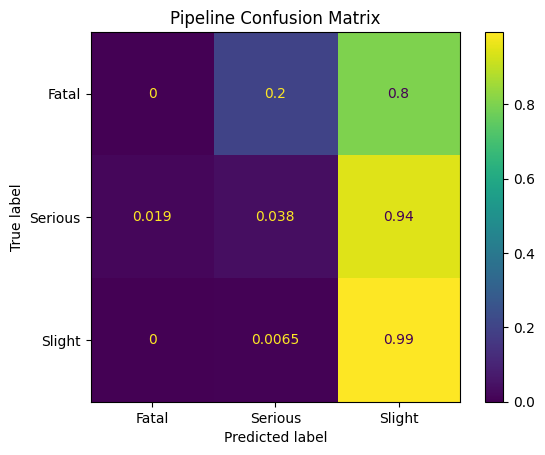

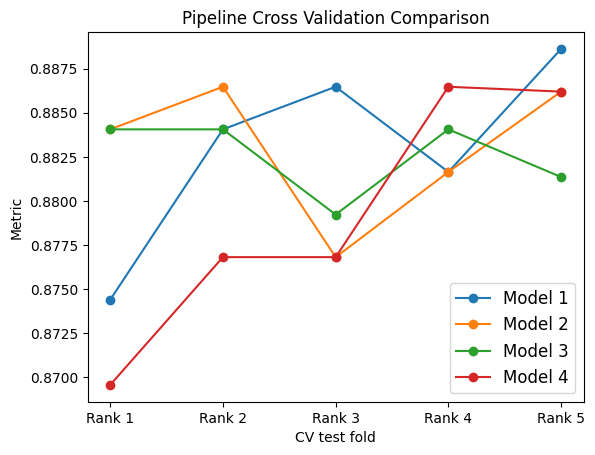

Running GridSearchCV for XGBoost...
Best Hyperparameters for Pipeline: {'model__n_estimators': 200}
Best Accuracy: 0.8748
Test Accuracy: 0.8726

Classification Report
              precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00         5
     Serious       0.20      0.06      0.09        53
      Slight       0.89      0.98      0.93       460

    accuracy                           0.87       518
   macro avg       0.36      0.34      0.34       518
weighted avg       0.81      0.87      0.84       518
 

Confusion Matrix:


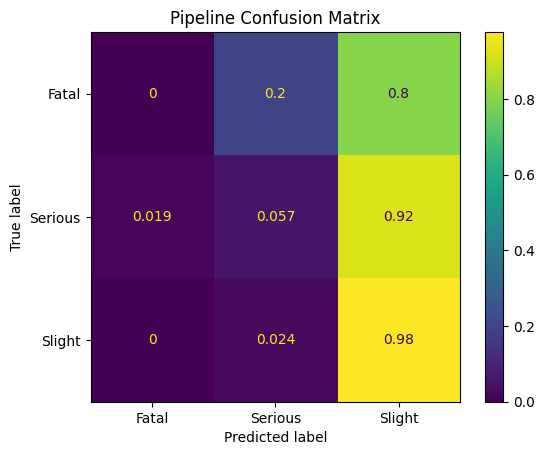

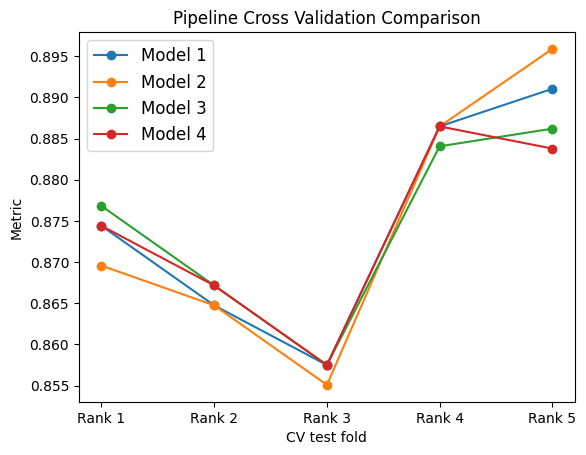

Running GridSearchCV for SVM...
Best Hyperparameters for Pipeline: {'model__C': 0.001}
Best Accuracy: 0.8874
Test Accuracy: 0.8880

Classification Report
              precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00         5
     Serious       0.00      0.00      0.00        53
      Slight       0.89      1.00      0.94       460

    accuracy                           0.89       518
   macro avg       0.30      0.33      0.31       518
weighted avg       0.79      0.89      0.84       518
 

Confusion Matrix:


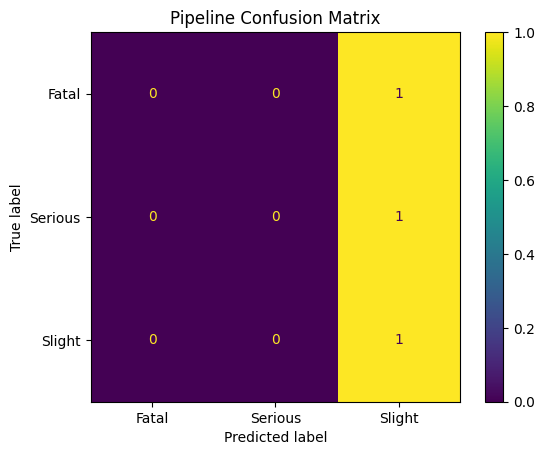

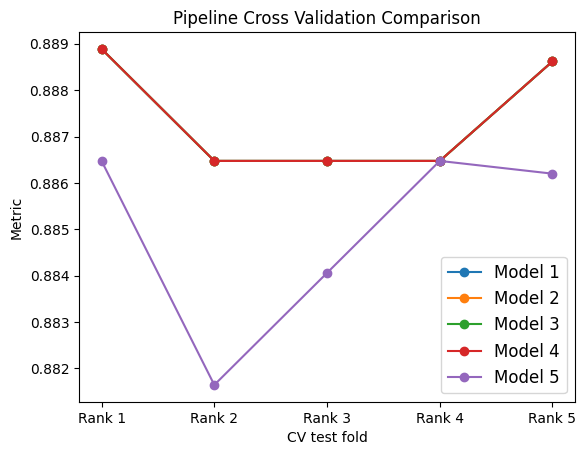

Running GridSearchCV for Naive Bayes...
Best Hyperparameters for Pipeline: {'model__alpha': 0.001}
Best Accuracy: 0.8874
Test Accuracy: 0.8880

Classification Report
              precision    recall  f1-score   support

       Fatal       0.00      0.00      0.00         5
     Serious       0.00      0.00      0.00        53
      Slight       0.89      1.00      0.94       460

    accuracy                           0.89       518
   macro avg       0.30      0.33      0.31       518
weighted avg       0.79      0.89      0.84       518
 

Confusion Matrix:


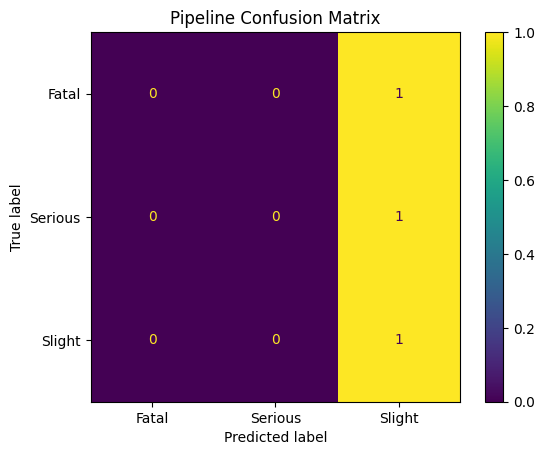

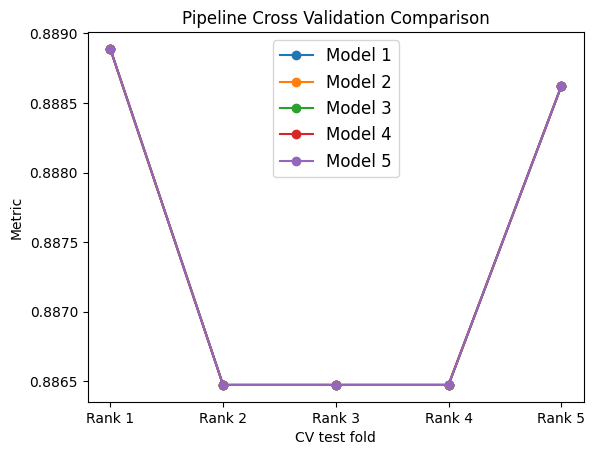

In [10]:
results = pipeline_utils.pipeline(X, y, with_over_sampling=False)

In [11]:
plot_utils.plot_models_comparison(results, metrics)

---

*******************************************************************************
*******************************************************************************
Using ADASYN Over Sampling...
*******************************************************************************
Running GridSearchCV for Random Forest...
Best Hyperparameters for Pipeline: {'model__n_estimators': 200}
Best Accuracy: 0.5930
Test Accuracy: 0.5097

Classification Report
              precision    recall  f1-score   support

       Fatal       0.03      0.40      0.06         5
     Serious       0.13      0.49      0.21        53
      Slight       0.92      0.51      0.66       460

    accuracy                           0.51       518
   macro avg       0.36      0.47      0.31       518
weighted avg       0.83      0.51      0.61       518
 

Confusion Matrix:


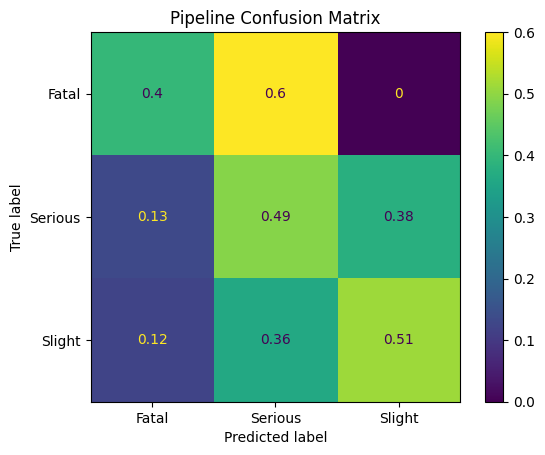

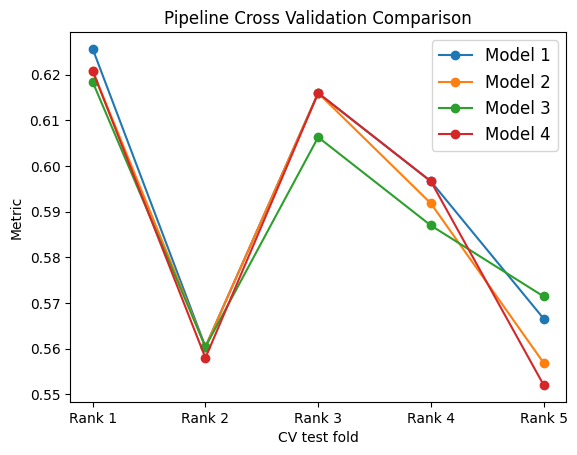

Running GridSearchCV for Gradient Boosting...
Best Hyperparameters for Pipeline: {'model__n_estimators': 200}
Best Accuracy: 0.6187
Test Accuracy: 0.5714

Classification Report
              precision    recall  f1-score   support

       Fatal       0.03      0.40      0.05         5
     Serious       0.18      0.58      0.28        53
      Slight       0.95      0.57      0.71       460

    accuracy                           0.57       518
   macro avg       0.39      0.52      0.35       518
weighted avg       0.86      0.57      0.66       518
 

Confusion Matrix:


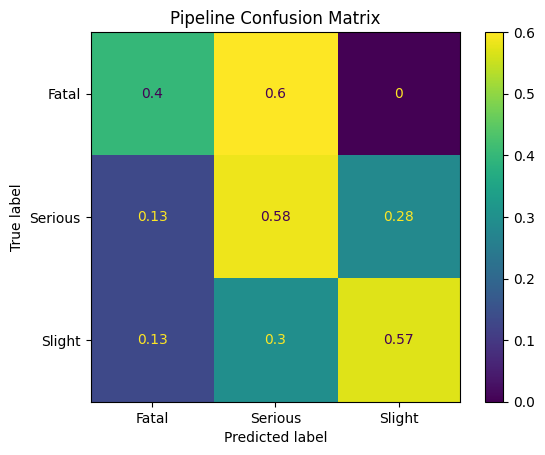

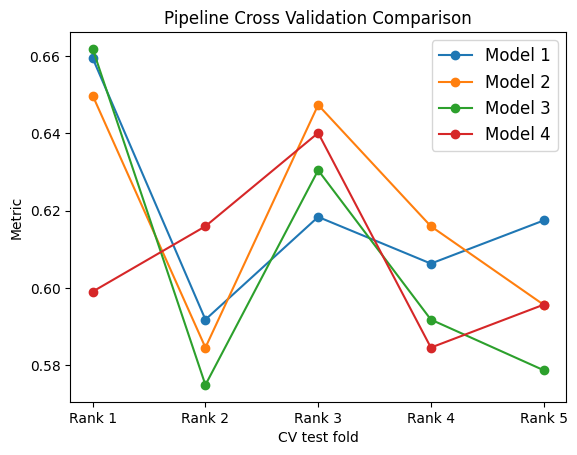

Running GridSearchCV for XGBoost...
Best Hyperparameters for Pipeline: {'model__n_estimators': 50}
Best Accuracy: 0.5998
Test Accuracy: 0.5386

Classification Report
              precision    recall  f1-score   support

       Fatal       0.03      0.40      0.06         5
     Serious       0.14      0.51      0.22        53
      Slight       0.93      0.54      0.69       460

    accuracy                           0.54       518
   macro avg       0.37      0.48      0.32       518
weighted avg       0.84      0.54      0.63       518
 

Confusion Matrix:


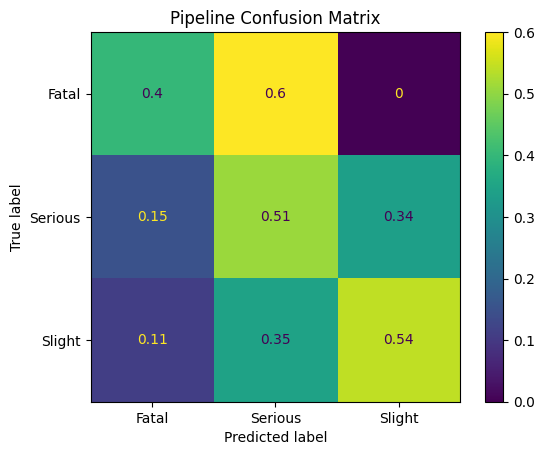

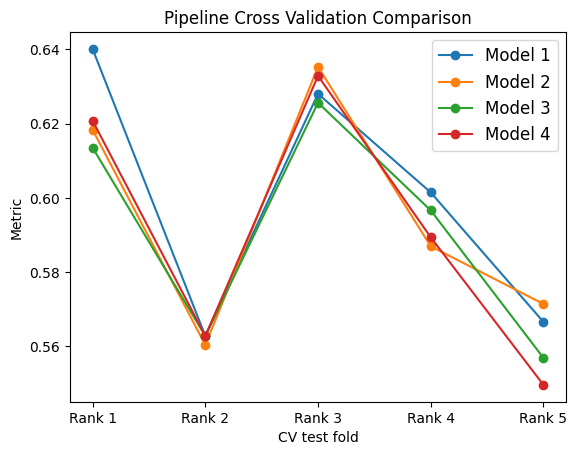

Running GridSearchCV for SVM...
Best Hyperparameters for Pipeline: {'model__C': 100}
Best Accuracy: 0.6162
Test Accuracy: 0.6100

Classification Report
              precision    recall  f1-score   support

       Fatal       0.03      0.40      0.06         5
     Serious       0.19      0.55      0.29        53
      Slight       0.94      0.62      0.75       460

    accuracy                           0.61       518
   macro avg       0.39      0.52      0.36       518
weighted avg       0.86      0.61      0.69       518
 

Confusion Matrix:


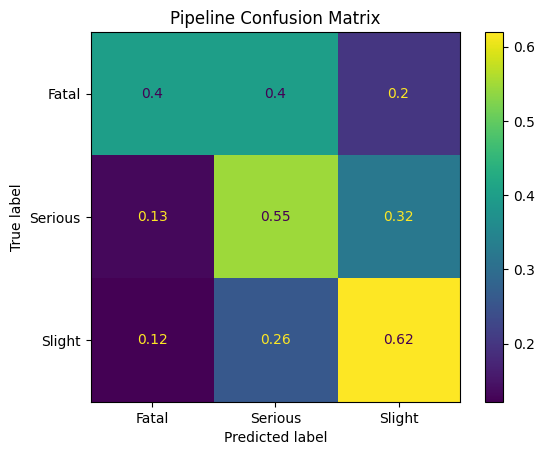

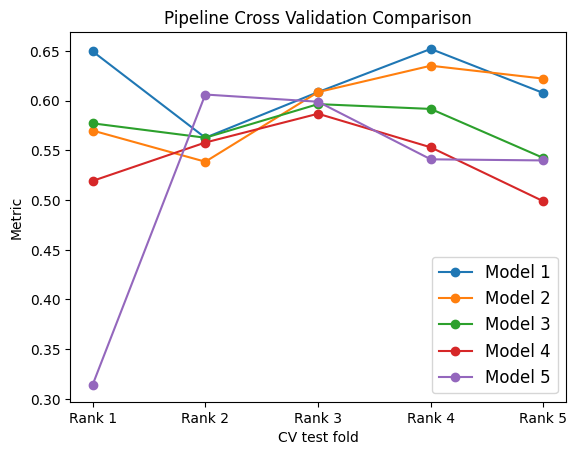

Running GridSearchCV for Naive Bayes...
Best Hyperparameters for Pipeline: {'model__alpha': 0.001}
Best Accuracy: 0.5384
Test Accuracy: 0.4942

Classification Report
              precision    recall  f1-score   support

       Fatal       0.02      0.60      0.04         5
     Serious       0.14      0.30      0.19        53
      Slight       0.92      0.52      0.66       460

    accuracy                           0.49       518
   macro avg       0.36      0.47      0.30       518
weighted avg       0.83      0.49      0.61       518
 

Confusion Matrix:


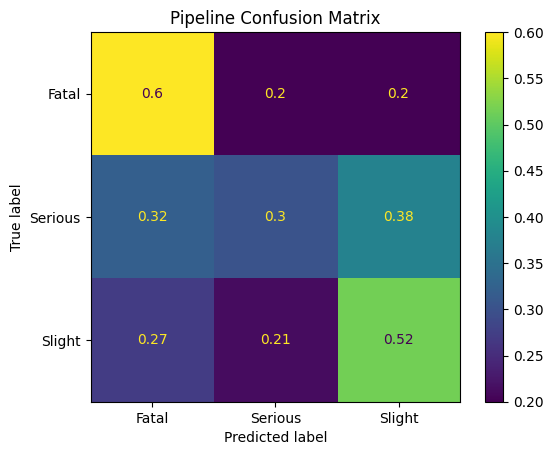

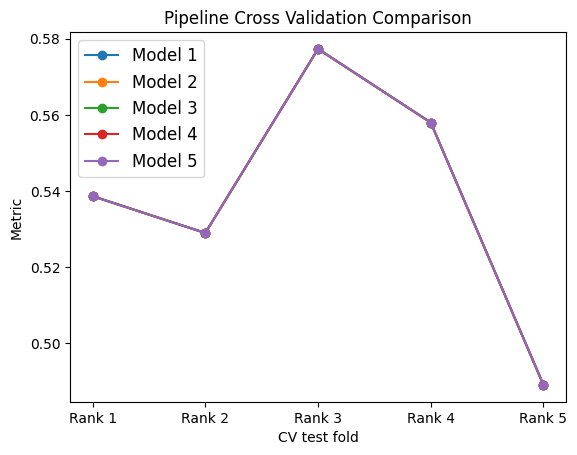

*******************************************************************************
*******************************************************************************
Using SMOTE Over Sampling...
*******************************************************************************
Running GridSearchCV for Random Forest...
Best Hyperparameters for Pipeline: {'model__n_estimators': 200}
Best Accuracy: 0.6153
Test Accuracy: 0.5946

Classification Report
              precision    recall  f1-score   support

       Fatal       0.03      0.40      0.06         5
     Serious       0.17      0.47      0.25        53
      Slight       0.93      0.61      0.74       460

    accuracy                           0.59       518
   macro avg       0.37      0.49      0.35       518
weighted avg       0.84      0.59      0.68       518
 

Confusion Matrix:


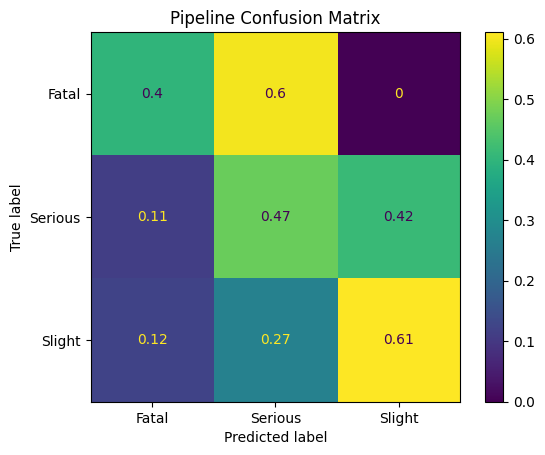

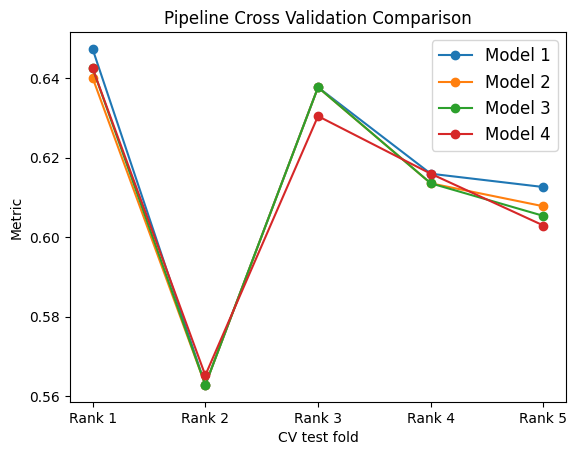

Running GridSearchCV for Gradient Boosting...
Best Hyperparameters for Pipeline: {'model__n_estimators': 400}
Best Accuracy: 0.6433
Test Accuracy: 0.6332

Classification Report
              precision    recall  f1-score   support

       Fatal       0.04      0.40      0.06         5
     Serious       0.19      0.51      0.28        53
      Slight       0.93      0.65      0.77       460

    accuracy                           0.63       518
   macro avg       0.39      0.52      0.37       518
weighted avg       0.85      0.63      0.71       518
 

Confusion Matrix:


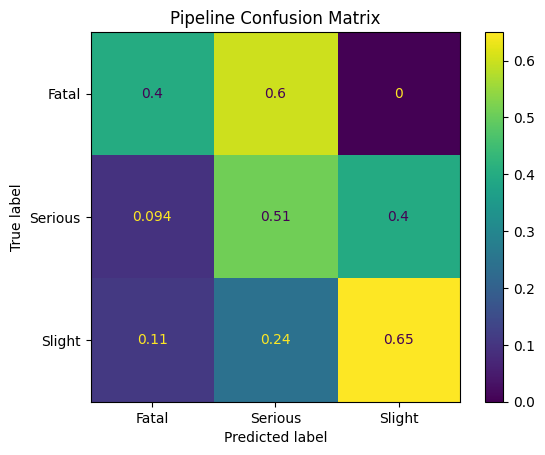

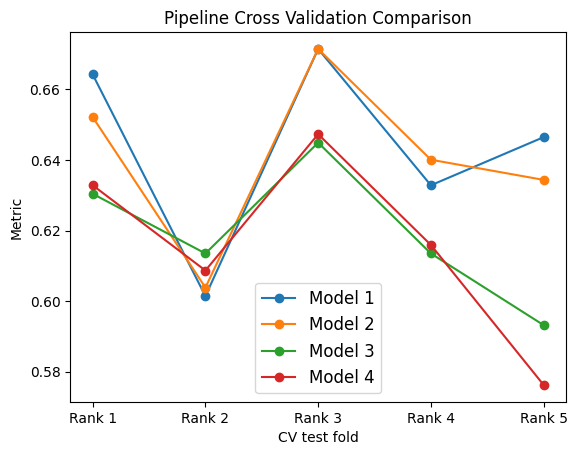

Running GridSearchCV for XGBoost...
Best Hyperparameters for Pipeline: {'model__n_estimators': 50}
Best Accuracy: 0.6264
Test Accuracy: 0.6100

Classification Report
              precision    recall  f1-score   support

       Fatal       0.03      0.40      0.06         5
     Serious       0.17      0.49      0.25        53
      Slight       0.94      0.63      0.75       460

    accuracy                           0.61       518
   macro avg       0.38      0.51      0.36       518
weighted avg       0.85      0.61      0.69       518
 

Confusion Matrix:


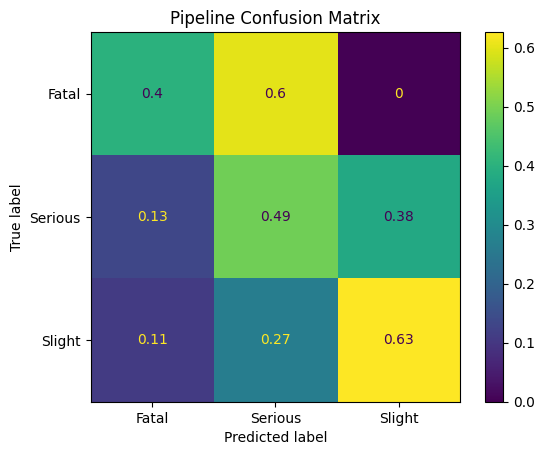

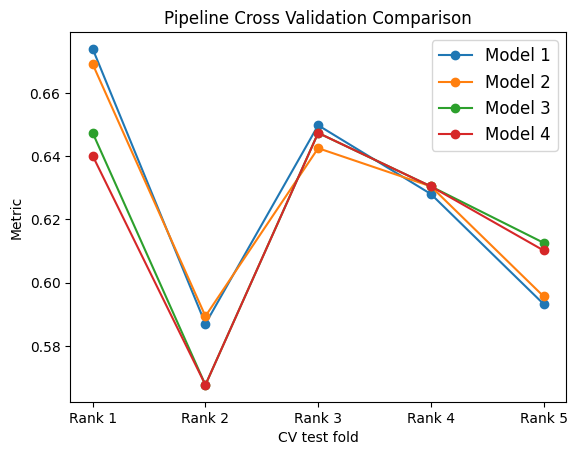

Running GridSearchCV for SVM...
Best Hyperparameters for Pipeline: {'model__C': 100}
Best Accuracy: 0.6327
Test Accuracy: 0.6158

Classification Report
              precision    recall  f1-score   support

       Fatal       0.03      0.40      0.06         5
     Serious       0.18      0.51      0.27        53
      Slight       0.94      0.63      0.75       460

    accuracy                           0.62       518
   macro avg       0.38      0.51      0.36       518
weighted avg       0.85      0.62      0.70       518
 

Confusion Matrix:


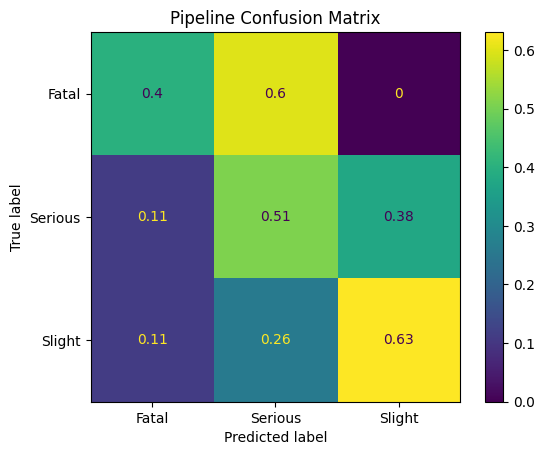

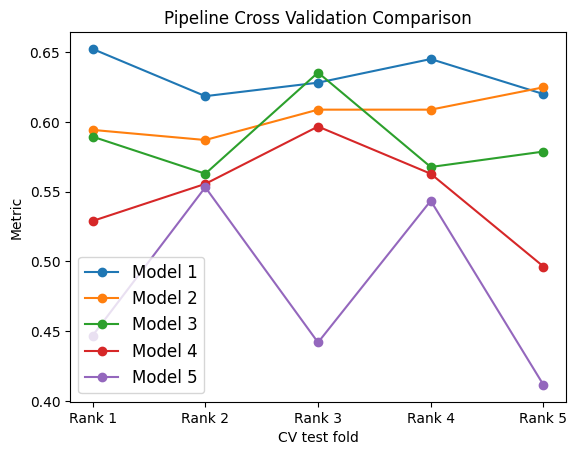

Running GridSearchCV for Naive Bayes...
Best Hyperparameters for Pipeline: {'model__alpha': 0.001}
Best Accuracy: 0.5476
Test Accuracy: 0.5116

Classification Report
              precision    recall  f1-score   support

       Fatal       0.01      0.40      0.03         5
     Serious       0.15      0.30      0.20        53
      Slight       0.92      0.54      0.68       460

    accuracy                           0.51       518
   macro avg       0.36      0.41      0.30       518
weighted avg       0.83      0.51      0.62       518
 

Confusion Matrix:


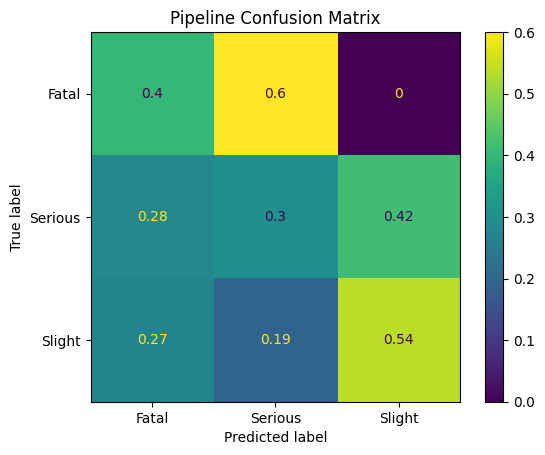

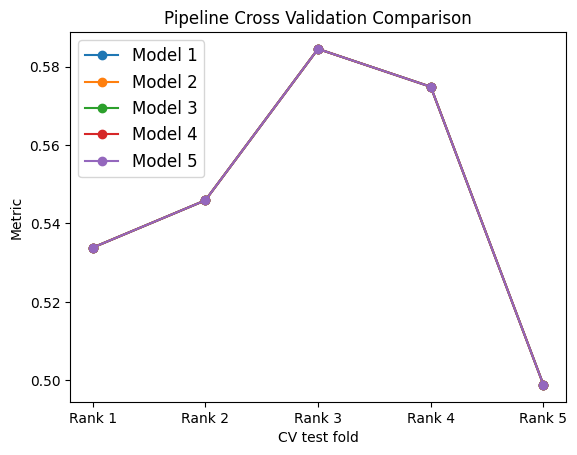

*******************************************************************************
*******************************************************************************
Using BorderlineSMOTE Over Sampling...
*******************************************************************************
Running GridSearchCV for Random Forest...
Best Hyperparameters for Pipeline: {'model__n_estimators': 400}
Best Accuracy: 0.6312
Test Accuracy: 0.6293

Classification Report
              precision    recall  f1-score   support

       Fatal       0.04      0.40      0.06         5
     Serious       0.18      0.47      0.26        53
      Slight       0.93      0.65      0.76       460

    accuracy                           0.63       518
   macro avg       0.38      0.51      0.36       518
weighted avg       0.84      0.63      0.71       518
 

Confusion Matrix:


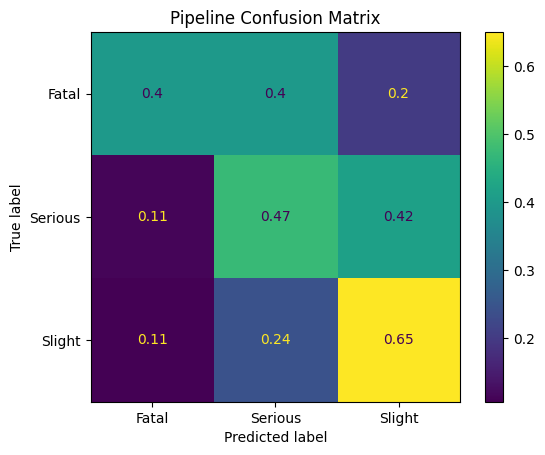

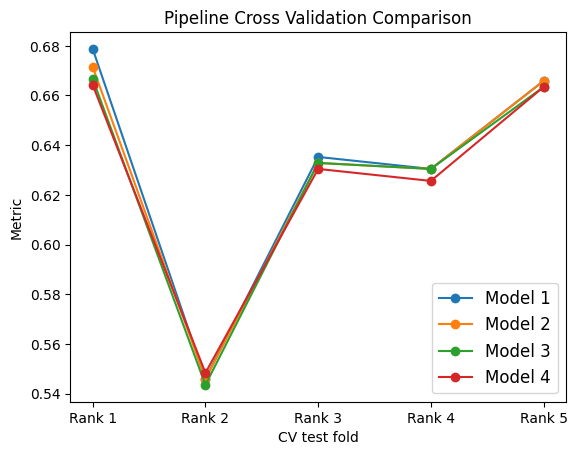

Running GridSearchCV for Gradient Boosting...
Best Hyperparameters for Pipeline: {'model__n_estimators': 200}
Best Accuracy: 0.6462
Test Accuracy: 0.6467

Classification Report
              precision    recall  f1-score   support

       Fatal       0.04      0.40      0.07         5
     Serious       0.20      0.51      0.28        53
      Slight       0.93      0.67      0.78       460

    accuracy                           0.65       518
   macro avg       0.39      0.52      0.38       518
weighted avg       0.85      0.65      0.72       518
 

Confusion Matrix:


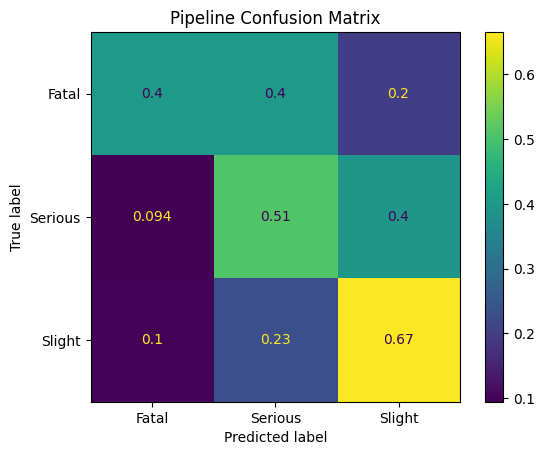

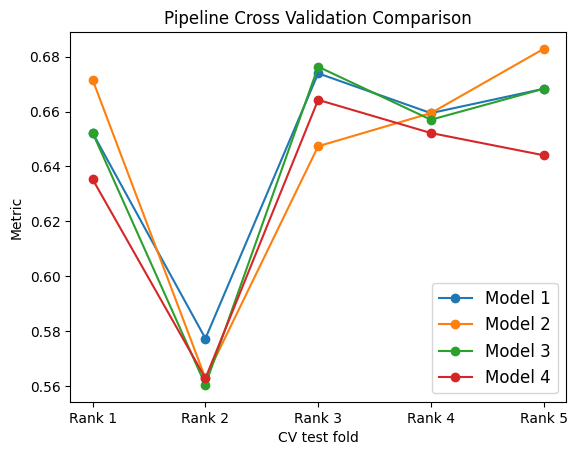

Running GridSearchCV for XGBoost...
Best Hyperparameters for Pipeline: {'model__n_estimators': 200}
Best Accuracy: 0.6288
Test Accuracy: 0.6409

Classification Report
              precision    recall  f1-score   support

       Fatal       0.04      0.40      0.07         5
     Serious       0.20      0.51      0.28        53
      Slight       0.94      0.66      0.77       460

    accuracy                           0.64       518
   macro avg       0.39      0.52      0.37       518
weighted avg       0.85      0.64      0.72       518
 

Confusion Matrix:


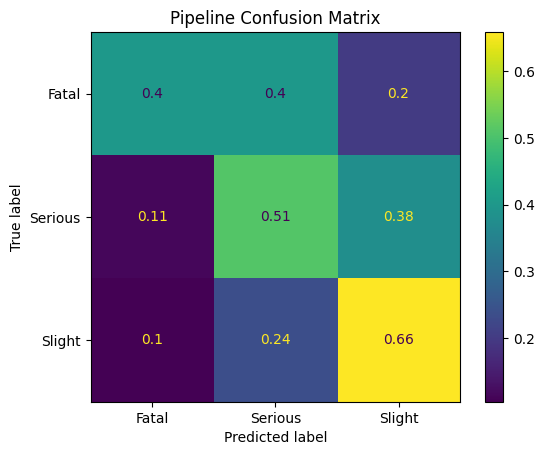

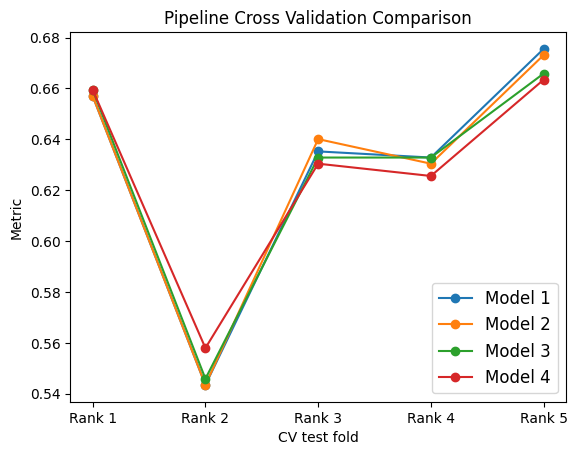

Running GridSearchCV for SVM...
Best Hyperparameters for Pipeline: {'model__C': 100}
Best Accuracy: 0.6433
Test Accuracy: 0.6371

Classification Report
              precision    recall  f1-score   support

       Fatal       0.03      0.40      0.06         5
     Serious       0.20      0.51      0.29        53
      Slight       0.93      0.65      0.77       460

    accuracy                           0.64       518
   macro avg       0.39      0.52      0.37       518
weighted avg       0.85      0.64      0.71       518
 

Confusion Matrix:


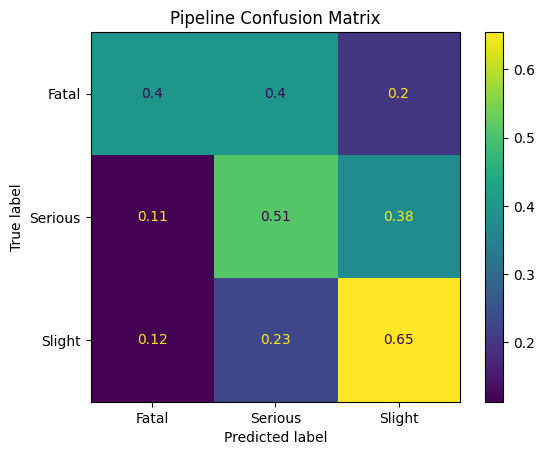

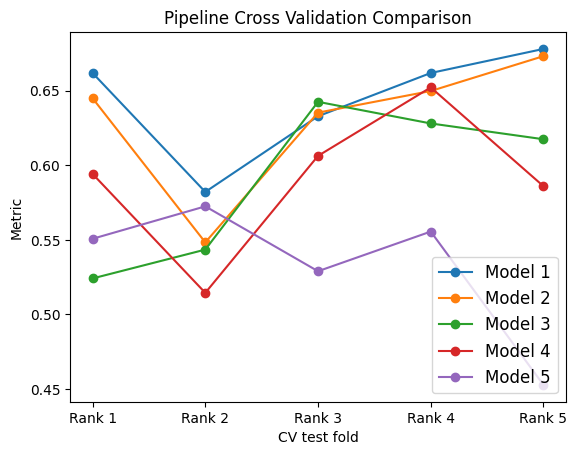

Running GridSearchCV for Naive Bayes...
Best Hyperparameters for Pipeline: {'model__alpha': 0.001}
Best Accuracy: 0.5897
Test Accuracy: 0.5927

Classification Report
              precision    recall  f1-score   support

       Fatal       0.03      0.60      0.06         5
     Serious       0.18      0.36      0.24        53
      Slight       0.93      0.62      0.74       460

    accuracy                           0.59       518
   macro avg       0.38      0.53      0.35       518
weighted avg       0.84      0.59      0.68       518
 

Confusion Matrix:


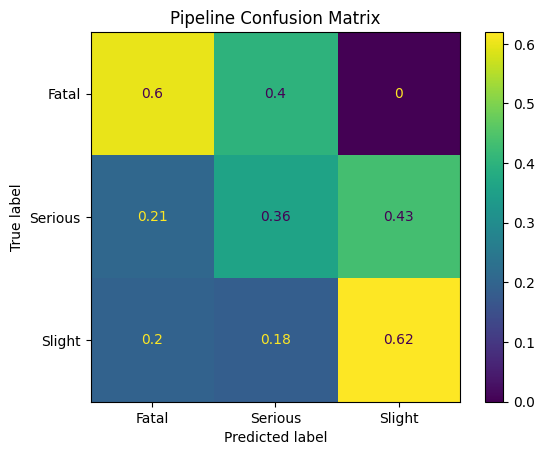

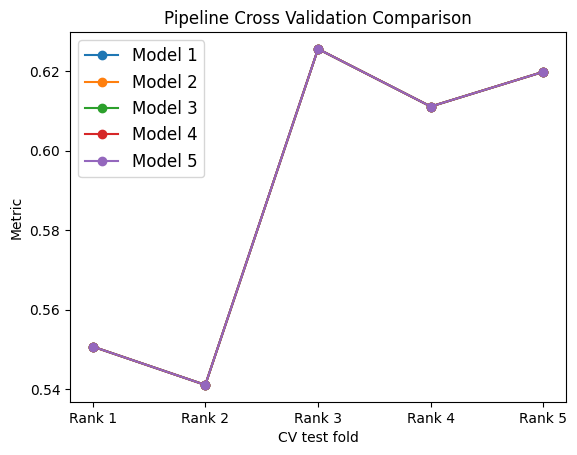

In [12]:
oversampling_results = pipeline_utils.pipeline(X, y, with_over_sampling=True)

In [13]:
plot_utils.plot_oversampling_comparison(oversampling_results, metrics)

---

**Observations:**
- The accuracy without oversampling techniques was consistently highly biased toward the majority class.
- The accuracy with oversampling reduced the models' accuracies, but they became more generalized.

---
---
---

## Conclusion:

In this Notebook, we conducted a thorough analysis of the Car Accidents Severity dataset, covering the following key steps:

### Data wrangling
- Loaded the dataset.
- Features Engineering.
- Dropped features with high cardinality or less relevance to modeling.
- Utilized Label Encoding to convert categorical features to a numerical representation.

### Feature Selection
- Utilized different feature selection approaches to find the top 5 common features between them to use instead of using all features.
- Validated the assumption of dropping features with high bias.

### Selected Models
- According to the nature of the features, being categorical, and the weak linear relationship between the features and the target, I thought of using tree-based, complex or naive bayes models, will be more suitable for these situations.

### Selected Sampling Techniques
- Due to the high imbalance in target classes, where the majority class almost having the Two-thirds of the data, I thought of using oversampling techniques for more generalization and reduce the model bias to the majority class, also will be more suitable for these situations.

### Methodology
- Now let's put all together and explain our simple pipeline:
  - we analyze our dataset to figure the most suitable features for our data modeling.
  - utilized different feature engineering techniques to get the best of our features.
  - used different feature selection approaches to get the best five features to use within our pipeline.
  - thought of the most suitable models to use.
  - thought of how to generalize our pipeline and solve the imbalance problem using different oversampling techniques.
  - used the grid search to find the best hyper-parameter for each model.
  - plotted each model cross-validation performance and print the best estimator performance on test data using different metrics.
  - plotted metrics over all models to compare them.
  - Finally, decided to have two paths, the first, not to use oversampling, the second to use oversampling, then compare between them.

### Comparison
- Oversampling helped to solve the generalization problem caused by imbalanced data and mitigated the models' bias toward the majority class.

---
---
---

# Thank You.